In [1]:
!pip install gputil
!pip install psutil

import csv
import gc
import math 
import numpy
import os
import time
import psutil


import GPUtil as gpuUtil
import pandas as pd
import tensorflow as tf
import threading
import textwrap

from keras import backend as K 
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn import utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

class MonitoringInfo:
  def __init__(self):
    self.platform = ""
    self.cpu_count = 0
    self.disk_value = 0
    self.gpu_load = 0
    self.ram_value = 0
    self.ram_total = 0
    self.ram_utilization = 0

class Monitor(threading.Thread):
  # Do this per algorithm as opposed to the entire program.
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()
        
        self.monitor_data = {}
        self.time_interval = 0
        

    def run(self):
        while not self.stopped:
            gpus_enabled = False            
            process = psutil.Process(os.getpid())
            monitoringInfo = MonitoringInfo()
          
            try:              
                gpu = gpuUtil.getGPUs()[0]

                monitoringInfo.cpu_count = psutil.cpu_count()
                monitoringInfo.platform = gpu.name
                monitoringInfo.gpu_load = gpu.load*100
                monitoringInfo.ram_value = gpu.memoryUsed
                monitoringInfo.ram_total = gpu.memoryTotal
                monitoringInfo.ram_utilization = gpu.memoryUtil*100

                gpus_enabled = True
                             
            except ValueError:
              # GPU may not be enabled in the runtime environmnent so we pass.
              pass

            if not gpus_enabled:
              monitoringInfo.cpu_count = psutil.cpu_count()
              
              monitoringInfo.ram_value = psutil.virtual_memory()[5] / (pow(1024,3))
              monitoringInfo.ram_total = psutil.virtual_memory()[1] / (pow(1024,3))
              monitoringInfo.ram_utilization =  monitoringInfo.ram_value / monitoringInfo.ram_total
              
              monitoringInfo.disk_value = psutil.disk_usage('/')[1] / (pow(1024,3))
            
            self.monitor_data[self.time_interval] = monitoringInfo
            self.time_interval += 1

            time.sleep(self.delay)


    def stop(self):
        self.stopped = True


def getProcessedDatasetFromUrl(lab):
  url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.{name}.data'.format(name=lab)
  print("url", url)
  column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 
                    'oldpeak', 'slope', 'ca', 'thal', 'num']
 
  raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)
  dataset = raw_dataset.copy()

  return dataset


def imputeDataset(dataset):
  if not dataset.isnull().any().any():
    return dataset

  threshold = int(dataset.shape[0] / 2)
  dataset = dataset.dropna(axis=1, thresh=threshold, how="any")
  dataset = dataset.fillna(dataset.median())
  return dataset


def getTrainTestValidateSplit(dataset):
  dataset = utils.shuffle(dataset, random_state=0)

  train = dataset[:math.ceil(len(dataset) * (0.5))]
  validate = dataset[len(train) : (len(train) + math.ceil(len(dataset) * (0.3))) ]
  test = dataset[(len(train) + len(validate)):]

  return train, test, validate


def getRepresentativeSampleArchetype(test_features, true_samples_indices):
  sess = tf.compat.v1.Session()
  with sess.as_default():
    true_predictions = tf.gather_nd(test_features, true_samples_indices)
    
    if tf.executing_eagerly():
      true_predictions_dataframe = pd.DataFrame(data=true_predictions.numpy(), columns=test_features.columns)
    else:
      true_predictions_dataframe = pd.DataFrame(data=true_predictions.eval(), columns=test_features.columns)

    mean = pd.Series.mean(true_predictions_dataframe)
    mode = true_predictions_dataframe.mode(axis=0, dropna=True).iloc[0]

  return mean, mode



def combineDatasets(imputed_cleveland_dataset, imputed_hungarian_dataset,
                    imputed_switzerland_dataset, imputed_long_beach_dataset):
  
  a = imputed_cleveland_dataset 
  b = imputed_long_beach_dataset 
  c = imputed_switzerland_dataset
  d = imputed_hungarian_dataset

  a_cols = set(a.columns)
  b_cols = set(b.columns)
  c_cols = set(c.columns)
  d_cols = set(d.columns)

  merge = pd.concat([a, b, c, d], join='outer', axis=0)
  merge = merge.dropna(axis=1, how="any")
    
  return merge



processed_cleveland_dataset =  getProcessedDatasetFromUrl("cleveland")
imputed_cleveland_dataset = imputeDataset(processed_cleveland_dataset)

processed_switzerland_dataset =  getProcessedDatasetFromUrl("switzerland")
imputed_switzerland_dataset = imputeDataset(processed_switzerland_dataset)

processed_hungarian_dataset =  getProcessedDatasetFromUrl("hungarian")
imputed_hungarian_dataset = imputeDataset(processed_hungarian_dataset)

processed_long_beach_dataset =  getProcessedDatasetFromUrl("va")
imputed_long_beach_dataset = imputeDataset(processed_long_beach_dataset)


datasets = [imputed_cleveland_dataset, imputed_hungarian_dataset,
              imputed_switzerland_dataset, imputed_long_beach_dataset]

names = ["imputed_cleveland_dataset",  "imputed_hungarian_dataset",
           "imputed_switzerland_dataset", "imputed_long_beach_dataset"]

combined_dataset = combineDatasets(imputed_cleveland_dataset, imputed_hungarian_dataset,
                    imputed_switzerland_dataset, imputed_long_beach_dataset)


def printMonitorData(monitor, subject):
  print("\nMonitoring Data for: ", subject)

  count_monitored_time_entries = len(list(monitor.monitor_data.keys()))
  if count_monitored_time_entries == 0:
    print("No time intervals captured")
    return
  
  time_intervals = []
  cpu_counts = []
  gpus = []
  disk = []
  ram_used = []
  ram_totals = []
  ram_utils = []

  for k in list(monitor.monitor_data.keys()):
    time_intervals += [k]
    cpu_counts += [monitor.monitor_data[k].cpu_count]
    gpus += [monitor.monitor_data[k].gpu_load]
    disk += [monitor.monitor_data[k].disk_value]
    ram_used += [monitor.monitor_data[k].ram_value]
    ram_totals += [monitor.monitor_data[k].ram_total]
    ram_utils += [monitor.monitor_data[k].ram_utilization]


  print("printing plot")
  plt.plot(time_intervals, cpu_counts, label="cpus")
  plt.plot(time_intervals, gpus, label="gpus")
  plt.plot(time_intervals, disk, label="disk")
  plt.xlabel("Time Interval")
  plt.ylabel("Count")
  plt.title("CPU, GPU & Disk")
  plt.legend()
  plt.show()


  plt.plot(time_intervals, ram_used, label="used ram")
  plt.plot(time_intervals, ram_totals, label="total ram")
  plt.xlabel("Time Interval")
  plt.ylabel("Gigabyte")
  plt.title("Ram Usage")
  plt.legend()
  plt.show()

  plt.plot(time_intervals, ram_utils, label = "ram utilization")
  plt.xlabel("Time Interval")
  plt.ylabel("Percent")
  plt.title("Ram Utilization")
  plt.legend()
  plt.show()

  print("Max Ram Used: ", max(ram_used))
  print("Max Ram Utilization: ", max(ram_utils))
  print("Max GPU: ", max(gpus))
  print("Max CPU: ", max(cpu_counts))


def main():
  tf.logging.set_verbosity(tf.logging.FATAL)

  # Instantiate monitor with a 10-second delay between updates
  
  monitor = Monitor(5)      
  
  for dataset, dataset_name in zip(datasets, names):
    print("\n\n")
    evaluateLogisticRegression(dataset.copy(), dataset_name)
    evaluateKnn(dataset.copy(), dataset_name)
    evaluateGradientBoosting(dataset.copy(), dataset_name)
  
  print("\n\n")
  evaluateLogisticRegression(combined_dataset.copy(), "Combined Dataset")
  evaluateKnn(combined_dataset.copy(), "Combined Dataset")
  evaluateGradientBoosting(combined_dataset.copy(), "Combined Dataset")
  
  monitor.stop()
  printMonitorData(monitor)

  return


# Remove comment to execute all cells
#main()


  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7412 sha256=7b28d84c96d717c44349b6787c8ed1ef9ed90d80fa2c633d7641cfcb9fa9b3c0
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
url http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
url http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data
url http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data
url http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data







Evaluate Logistic Regression for:  imputed_cleveland_dataset
Train on 200 samples
200/200 [==============================] - 0s 66us/sample - loss: 0.2523 - accuracy: 0.5350
Tensorflow accuracy =  0.5533980582524272
Archetype of a True prediction:
Mean Archetpye:
age          52.403509
sex           0.578947
cp            2.947368
trestbps    130.947368
chol        241.070175
fbs           0.140351
restecg       0.807018
thalach     158.000000
exang         0.105263
oldpeak       0.457895
slope         1.403509
ca            0.228070
thal          3.719298
dtype: float64
Mode Archetype:
age          44.0
sex           1.0
cp            3.0
trestbps    140.0
chol        219.0
fbs           0.0
restecg       0.0
thalach     152.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
Name: 0, dtype: float64
Elapsed Time: 1802.15ms

Monitoring Data for:  Tensorflow Logistic Regression
printing plot


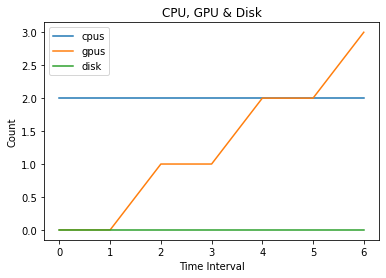

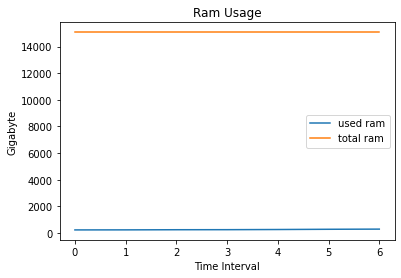

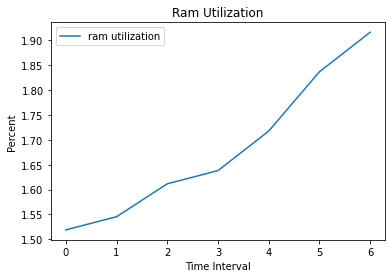

Max Ram Used:  289.0
Max Ram Utilization:  1.9165727170236753
Max GPU:  3.0
Max CPU:  2
sklearn accuracy =  0.8349514563106796
Elapsed Time: 20.35ms

Monitoring Data for:  SkLearn Logistic Regression
printing plot


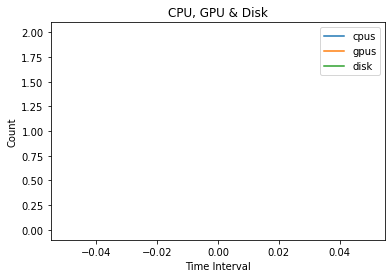

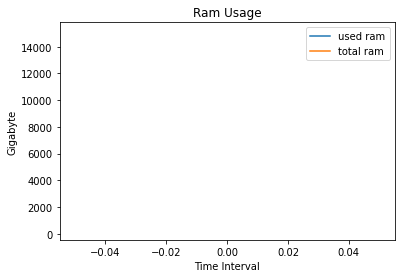

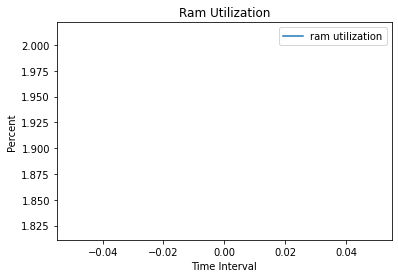

Max Ram Used:  289.0
Max Ram Utilization:  1.9165727170236753
Max GPU:  0.0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          54.023256
sex           0.674419
cp            3.267442
trestbps    132.965116
chol        249.244186
fbs           0.151163
restecg       0.883721
thalach     149.151163
exang         0.290698
oldpeak       1.144186
slope         1.616279
ca            0.662791
thal          4.546512
dtype: float64
Mode Archetype:
age          44.0
sex           1.0
cp            4.0
trestbps    140.0
chol        234.0
fbs           0.0
restecg       0.0
thalach     160.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
Name: 0, dtype: float64





Evaluate Logistic Regression for:  imputed_hungarian_dataset
Train on 194 samples
194/194 [==============================] - 0s 57us/sample - loss: 0.2321 - accuracy: 0.6237
Tensorflow accuracy =  0.67
Archetype of a True prediction:
Mean Archetpye:
age          47.49253

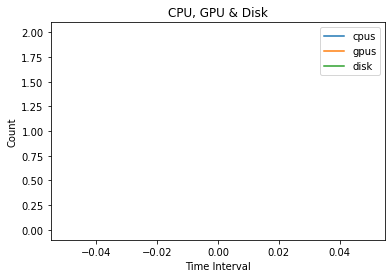

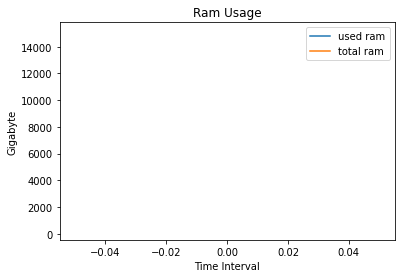

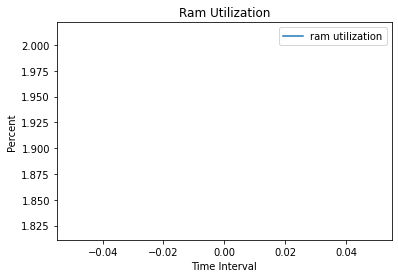

Max Ram Used:  289.0
Max Ram Utilization:  1.9165727170236753
Max GPU:  0.0
Max CPU:  2
sklearn accuracy =  0.73
Elapsed Time: 16.94ms

Monitoring Data for:  SkLearn Logistic Regression
printing plot


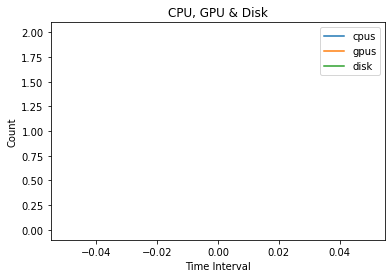

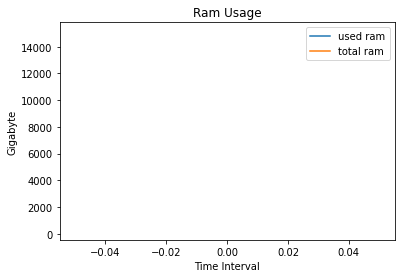

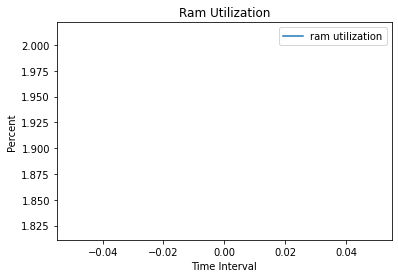

Max Ram Used:  289.0
Max Ram Utilization:  1.9165727170236753
Max GPU:  0.0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          47.178082
sex           0.753425
cp            2.794521
trestbps    130.958904
chol        245.424658
fbs           0.027397
restecg       0.178082
thalach     137.698630
exang         0.232877
oldpeak       0.493151
dtype: float64
Mode Archetype:
age          54.0
sex           1.0
cp            2.0
trestbps    120.0
chol        243.0
fbs           0.0
restecg       0.0
thalach     150.0
exang         0.0
oldpeak       0.0
Name: 0, dtype: float64





Evaluate Logistic Regression for:  imputed_switzerland_dataset
Train on 81 samples
81/81 [==============================] - 0s 70us/sample - loss: 0.1605 - accuracy: 0.9259
Tensorflow accuracy =  0.9523809523809523
Archetype of a True prediction:
Mean Archetpye:
age          57.5500
sex           0.9000
cp            3.8500
trestbps    134.2500
chol          0.0000
restecg       0.3750
thala

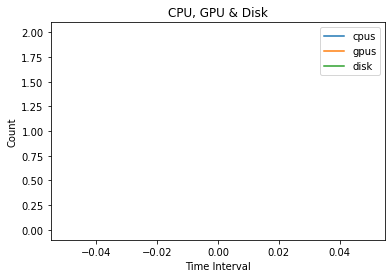

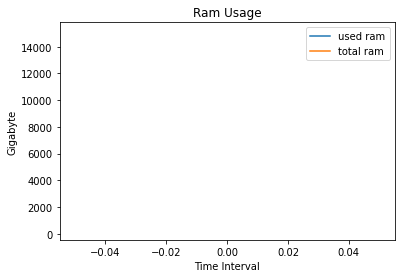

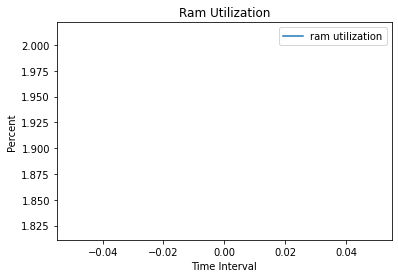

Max Ram Used:  289.0
Max Ram Utilization:  1.9165727170236753
Max GPU:  0.0
Max CPU:  2
sklearn accuracy =  0.8333333333333334
Elapsed Time: 16.54ms

Monitoring Data for:  SkLearn Logistic Regression
printing plot


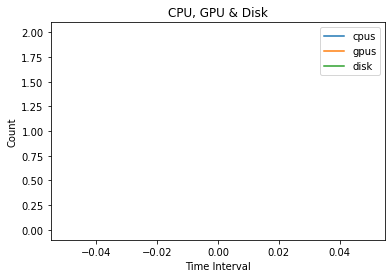

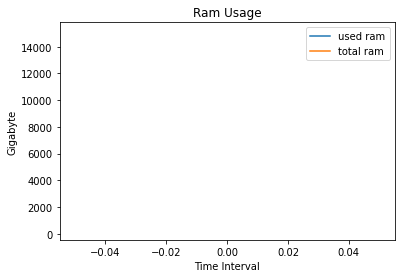

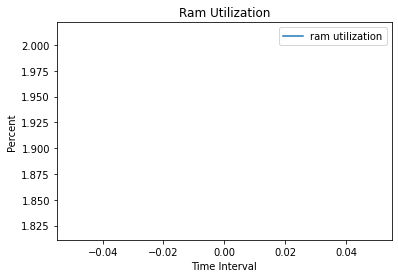

Max Ram Used:  289.0
Max Ram Utilization:  1.9165727170236753
Max GPU:  0.0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          56.600000
sex           0.885714
cp            3.857143
trestbps    134.428571
chol          0.000000
restecg       0.314286
thalach     112.857143
exang         0.600000
oldpeak       0.797143
slope         1.857143
thal          6.200000
dtype: float64
Mode Archetype:
age          60.0
sex           1.0
cp            4.0
trestbps    130.0
chol          0.0
restecg       0.0
thalach     120.0
exang         1.0
oldpeak       0.0
slope         2.0
thal          7.0
Name: 0, dtype: float64





Evaluate Logistic Regression for:  imputed_long_beach_dataset
Train on 132 samples
132/132 [==============================] - 0s 96us/sample - loss: 0.2770 - accuracy: 0.2955
Tensorflow accuracy =  0.3088235294117647
Archetype of a True prediction:
Mean Archetpye:
age          59.142857
sex           0.952381
cp            3.047619
trestbps    129.619

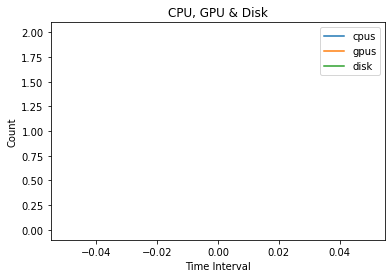

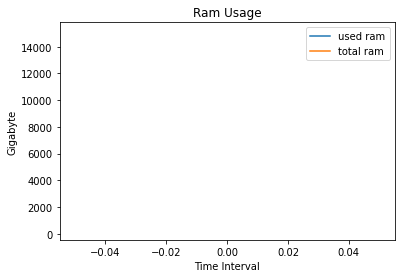

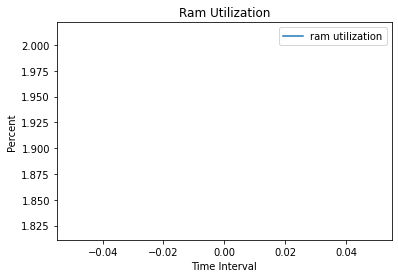

Max Ram Used:  289.0
Max Ram Utilization:  1.9165727170236753
Max GPU:  0.0
Max CPU:  2
sklearn accuracy =  0.6911764705882353
Elapsed Time: 5.26ms

Monitoring Data for:  SkLearn Logistic Regression
printing plot


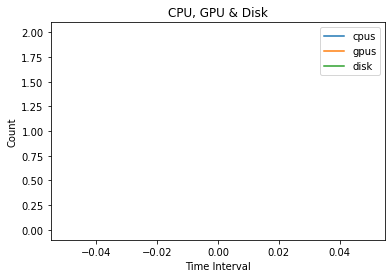

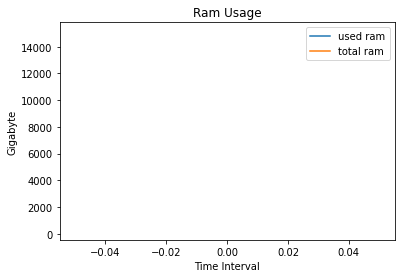

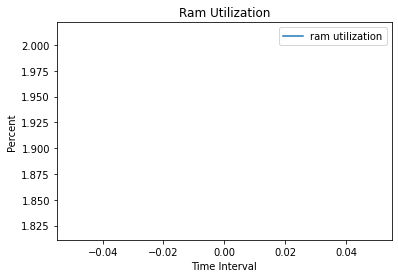

Max Ram Used:  289.0
Max Ram Utilization:  1.9165727170236753
Max GPU:  0.0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          60.851064
sex           0.978723
cp            3.744681
trestbps    132.489362
chol        181.468085
fbs           0.382979
restecg       0.787234
thalach     122.531915
exang         0.787234
oldpeak       1.563830
dtype: float64
Mode Archetype:
age          64.0
sex           1.0
cp            4.0
trestbps    130.0
chol          0.0
fbs           0.0
restecg       1.0
thalach     120.0
exang         1.0
oldpeak       1.5
Name: 0, dtype: float64





Evaluate Logistic Regression for:  Combined Dataset
Train on 607 samples
607/607 [==============================] - 0s 61us/sample - loss: 0.2696 - accuracy: 0.5717
Tensorflow accuracy =  0.5333333333333333
Archetype of a True prediction:
Mean Archetpye:
age          54.333333
sex           0.708333
cp            3.625000
trestbps    139.333333
chol        192.208333
restecg       0.666667
t

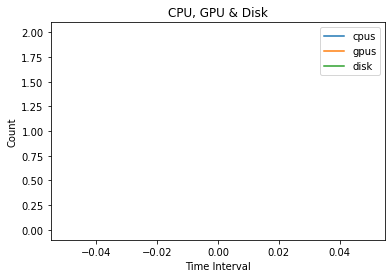

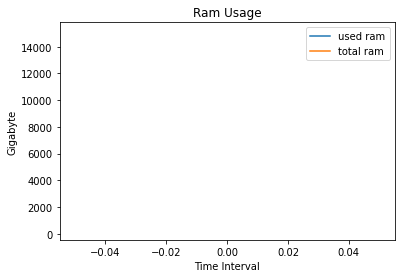

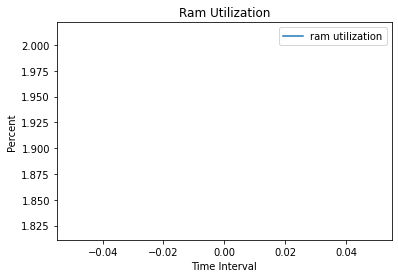

Max Ram Used:  289.0
Max Ram Utilization:  1.9165727170236753
Max GPU:  0.0
Max CPU:  2
sklearn accuracy =  0.6444444444444445
Elapsed Time: 24.84ms


In [ ]:
def doLogisticRegression(train_features, train_labels, test_features, test_labels):
  tf.get_logger().setLevel('FATAL')

  with tf.compat.v1.Session():
    tf_logistic_regression_monitor = Monitor(0.25)      
    start_time = time.time()
      
    normalized_train = tf.keras.utils.normalize(train_features.copy())
    normalized_test_features = tf.keras.utils.normalize(test_features.copy())

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, input_shape=train_features.to_numpy()[0].shape, activation='sigmoid'))
    model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])

    model.fit(
        normalized_train,
        train_labels,
        shuffle=True,
    )
    
    predictions = model.predict(normalized_test_features)
    
    # Logistic regression computes likeliness, we need to convert this to classes
    # Using 0.5 because that's the split for diameter narrowing for the dataset
    # 'num' column - our target value.
    new_labels = []
    for p in predictions:
        if p > 0.5:
            new_labels += [1]
        else:
            new_labels += [0]
            
    equals = (tf.equal(test_labels, new_labels))
    equals_as_ints = tf.cast(equals, tf.int32)
    equals_count = tf.reduce_sum(equals_as_ints)

    if tf.executing_eagerly():
      print("Tensorflow accuracy = ", equals_count.numpy() / len(test_labels))
    else:
      print("Tensorflow accuracy = ", equals_count.eval() / len(test_labels))
    

    # Determine and print model archetypical true sample
    true_samples_indices = tf.where(equals)
    print("Archetype of a True prediction:")
    mean_archetype, mode_archetype = getRepresentativeSampleArchetype(test_features, true_samples_indices)

    print("Mean Archetpye:")
    print(mean_archetype)
    print("Mode Archetype:")
    print(mode_archetype)

    tf_logistic_regression_monitor.stop()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Elapsed Time: {t:.2F}ms".format(t=(elapsed_time * 1000)))
    printMonitorData(tf_logistic_regression_monitor, "Tensorflow Logistic Regression") 

  
  gc.collect()
  tf.compat.v1.reset_default_graph()
  K.clear_session()

  return

    
    
def doSkLearnLogisticRegression(train_features, train_labels, test_features, test_labels): 
  with tf.compat.v1.Session():
    sklearn_logistic_regression_monitor = Monitor(0.25)      
    start_time = time.time()
  
    scaler = preprocessing.StandardScaler().fit(train_features)
    train_features_scaled = scaler.transform(train_features)
    test_features_scaled = scaler.transform(test_features)

    model = SGDClassifier(loss='log').fit(train_features_scaled, train_labels)
    predictions = model.predict(test_features_scaled)

    print("sklearn accuracy = ", model.score(test_features_scaled, test_labels))
    
    sklearn_logistic_regression_monitor.stop()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Elapsed Time: {t:.2F}ms".format(t=(elapsed_time * 1000)))
    
    # Allow monitoring thread to process.
    time.sleep(2)
    printMonitorData(sklearn_logistic_regression_monitor,"SkLearn Logistic Regression") 

    equals = (tf.equal(test_labels, predictions))
    true_samples_indices = tf.where(equals)
    print("Archetype of a True prediction:")
    mean_archetype, mode_archetype = getRepresentativeSampleArchetype(test_features, true_samples_indices)

    print("Mean Archetpye:")
    print(mean_archetype)
    print("Mode Archetype:")
    print(mode_archetype)

  gc.collect()
  tf.compat.v1.reset_default_graph()
  K.clear_session()

  return

  
def evaluateLogisticRegression(dataset, dataset_name):
  print("\nEvaluate Logistic Regression for: ", dataset_name)
  tf.get_logger().setLevel('FATAL')

  train_dataset = dataset.sample(frac=0.66, random_state=0)
  test_dataset = dataset.drop(train_dataset.index)
    
  train_features = train_dataset.copy()
  test_features = test_dataset.copy()

  train_labels = train_features.pop('num')
  train_labels = train_labels.replace([1,2,3,4], 1)
  test_labels = test_features.pop('num')
  test_labels = test_labels.replace([1,2,3,4], 1)

 
  doLogisticRegression(train_features, train_labels, test_features, test_labels)
  doSkLearnLogisticRegression(train_features, train_labels, test_features, test_labels)

  return

for dataset, dataset_name in zip(datasets, names):
  print("\n\n\n")
  evaluateLogisticRegression(dataset.copy(), dataset_name)

print("\n\n\n")
evaluateLogisticRegression(combined_dataset.copy(), "Combined Dataset")







Evaluate KNN for:  imputed_cleveland_dataset
Optimal k =  26
Tensorflow accuracy =  0.6043956043956044
Archetype of a True prediction:
Mean Archetpye:
age          53.036364
sex           0.654545
cp            2.709091
trestbps    128.836364
chol        241.545455
fbs           0.127273
restecg       0.927273
thalach     158.963636
exang         0.109091
oldpeak       0.507273
slope         1.381818
ca            0.236364
thal          3.800000
dtype: float64
Mode Archetype:
age          52.0
sex           1.0
cp            3.0
trestbps    140.0
chol        197.0
fbs           0.0
restecg       0.0
thalach     162.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
Name: 0, dtype: float64
Elapsed Time: 87.26ms

Monitoring Data for:  Tensorflow Nearest Neighbors
printing plot


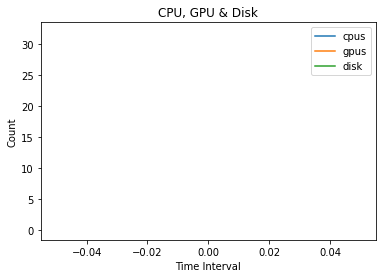

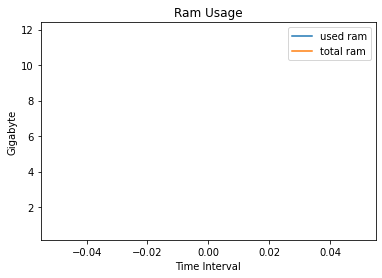

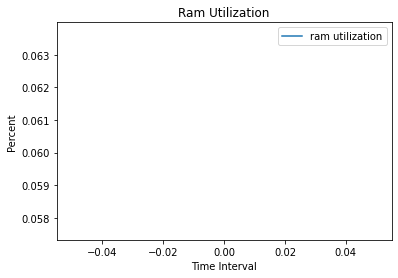

Max Ram Used:  0.7187232971191406
Max Ram Utilization:  0.06065795281461671
Max GPU:  0
Max CPU:  2
sklearn accuracy =  0.5714285714285714
Elapsed Time: 27.87ms

Monitoring Data for:  SkLearn Nearest Neighbors
printing plot


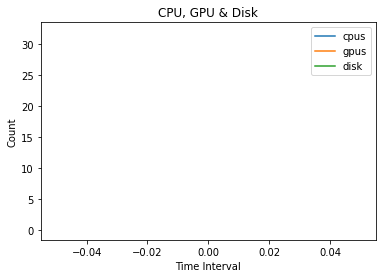

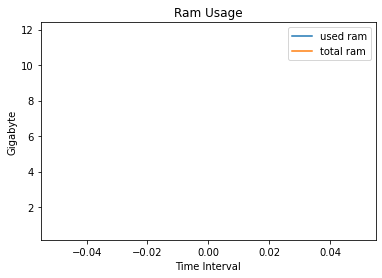

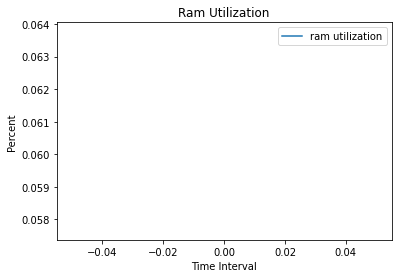

Max Ram Used:  0.7193679809570312
Max Ram Utilization:  0.06071333940108286
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          52.730769
sex           0.653846
cp            2.673077
trestbps    128.576923
chol        240.807692
fbs           0.134615
restecg       0.942308
thalach     159.903846
exang         0.115385
oldpeak       0.517308
slope         1.365385
ca            0.250000
thal          3.634615
dtype: float64
Mode Archetype:
age          52.0
sex           1.0
cp            3.0
trestbps    140.0
chol        197.0
fbs           0.0
restecg       0.0
thalach     162.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
Name: 0, dtype: float64





Evaluate KNN for:  imputed_hungarian_dataset
Optimal k =  16
Tensorflow accuracy =  0.5730337078651685
Archetype of a True prediction:
Mean Archetpye:
age          47.156863
sex           0.686275
cp            2.686275
trestbps    129.176471
chol        237.

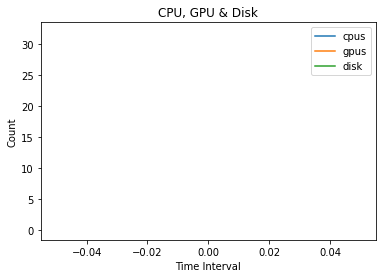

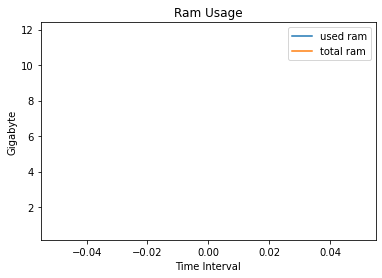

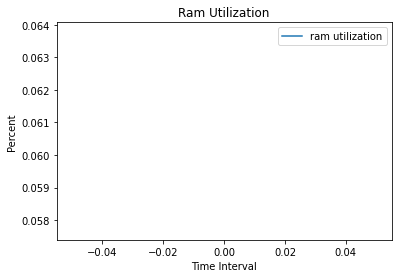

Max Ram Used:  0.7196197509765625
Max Ram Utilization:  0.060734959852158064
Max GPU:  0
Max CPU:  2
sklearn accuracy =  0.5617977528089888
Elapsed Time: 22.43ms

Monitoring Data for:  SkLearn Nearest Neighbors
printing plot


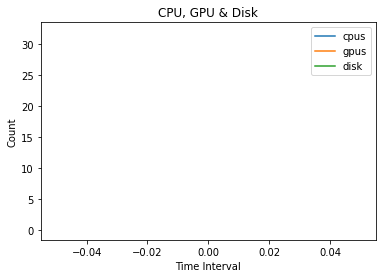

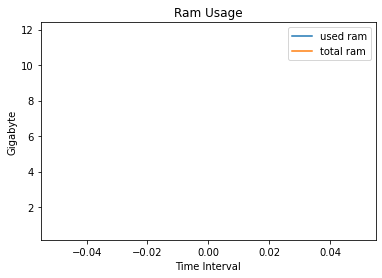

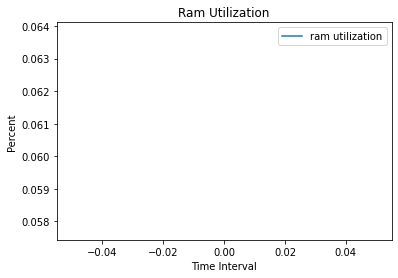

Max Ram Used:  0.7200546264648438
Max Ram Utilization:  0.06077313023894499
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          46.620000
sex           0.720000
cp            2.720000
trestbps    130.000000
chol        238.064871
fbs           0.060000
restecg       0.300000
thalach     145.280000
exang         0.120000
oldpeak       0.370000
dtype: float64
Mode Archetype:
age          48.000000
sex           1.000000
cp            2.000000
trestbps    120.000000
chol        250.848708
fbs           0.000000
restecg       0.000000
thalach     170.000000
exang         0.000000
oldpeak       0.000000
Name: 0, dtype: float64





Evaluate KNN for:  imputed_switzerland_dataset
Optimal k =  23
Tensorflow accuracy =  0.43243243243243246
Archetype of a True prediction:
Mean Archetpye:
age          56.312500
sex           0.812500
cp            3.250000
trestbps    125.625000
chol          0.000000
restecg       0.250000
thalach     126.062500
exang         0.5

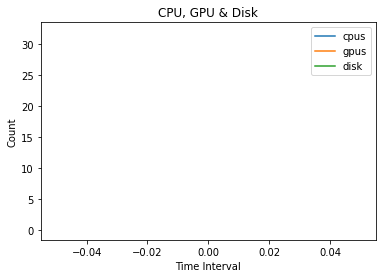

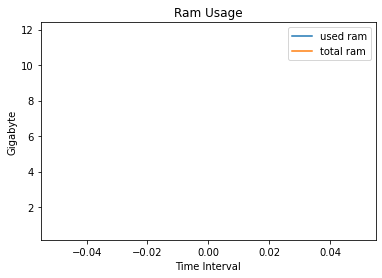

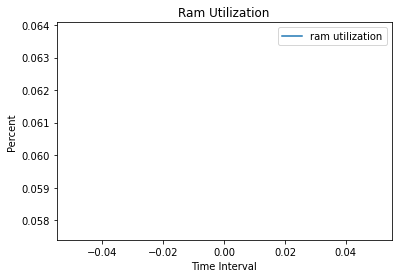

Max Ram Used:  0.7197074890136719
Max Ram Utilization:  0.06074107413638901
Max GPU:  0
Max CPU:  2
sklearn accuracy =  0.4864864864864865
Elapsed Time: 21.31ms

Monitoring Data for:  SkLearn Nearest Neighbors
printing plot


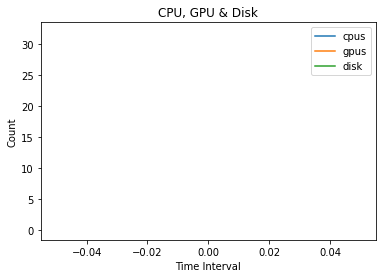

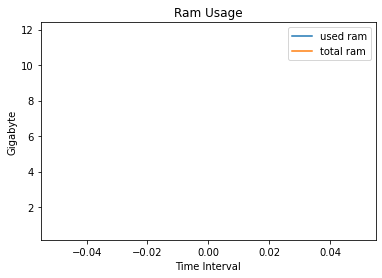

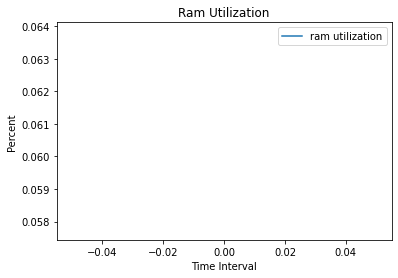

Max Ram Used:  0.7201499938964844
Max Ram Utilization:  0.06078037698817702
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          55.388889
sex           0.833333
cp            3.277778
trestbps    130.555556
chol          0.000000
restecg       0.222222
thalach     116.666667
exang         0.388889
oldpeak       0.477778
slope         1.689203
thal          4.985133
dtype: float64
Mode Archetype:
age          51.0
sex           1.0
cp            4.0
trestbps    120.0
chol          0.0
restecg       0.0
thalach     110.0
exang         0.0
oldpeak       0.0
slope         2.0
thal          3.0
Name: 0, dtype: float64





Evaluate KNN for:  imputed_long_beach_dataset
Optimal k =  29
Tensorflow accuracy =  0.18333333333333332
Archetype of a True prediction:
Mean Archetpye:
age          64.363636
sex           1.000000
cp            3.090909
trestbps    132.641414
chol        206.363636
fbs           0.545455
restecg       0.545455
thalach     123.107607
exan

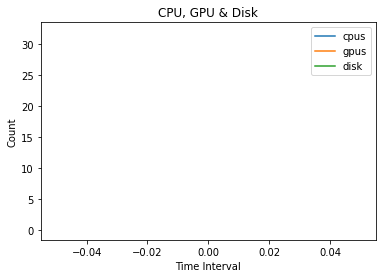

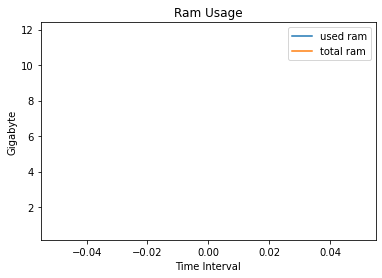

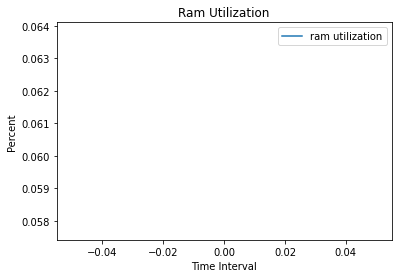

Max Ram Used:  0.7199440002441406
Max Ram Utilization:  0.06076076108303017
Max GPU:  0
Max CPU:  2
sklearn accuracy =  0.13333333333333333
Elapsed Time: 20.69ms

Monitoring Data for:  SkLearn Nearest Neighbors
printing plot


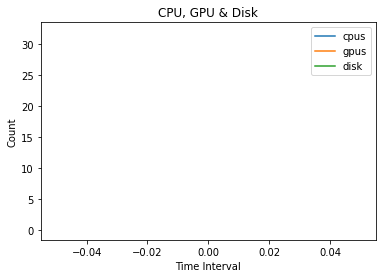

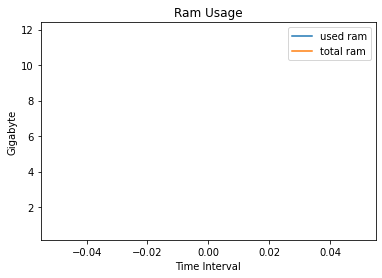

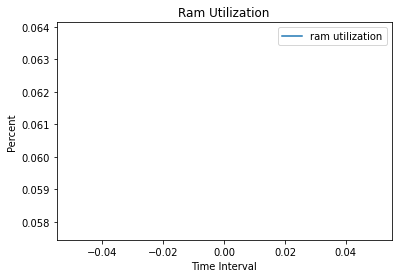

Max Ram Used:  0.7203140258789062
Max Ram Utilization:  0.060794436529592155
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          59.625000
sex           1.000000
cp            3.250000
trestbps    127.470486
chol        204.000000
fbs           0.250000
restecg       0.750000
thalach     101.599490
exang         0.580782
oldpeak       0.665104
dtype: float64
Mode Archetype:
age          62.0
sex           1.0
cp            3.0
trestbps    120.0
chol        220.0
fbs           0.0
restecg       0.0
thalach      86.0
exang         1.0
oldpeak       0.0
Name: 0, dtype: float64





Evaluate KNN for:  Combined Dataset
Optimal k =  60
Tensorflow accuracy =  0.4601449275362319
Archetype of a True prediction:
Mean Archetpye:
age          50.322835
sex           0.590551
cp            2.866142
trestbps    128.185258
chol        211.701514
restecg       0.554021
thalach     146.736944
exang         0.191280
oldpeak       0.456234
dtype: float64
Mode Archetype:
a

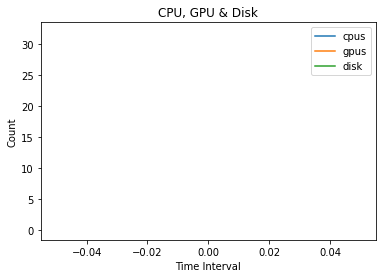

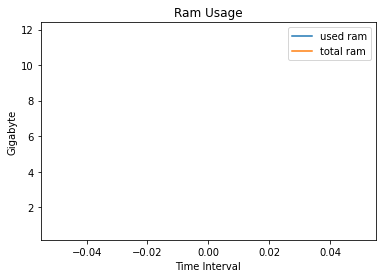

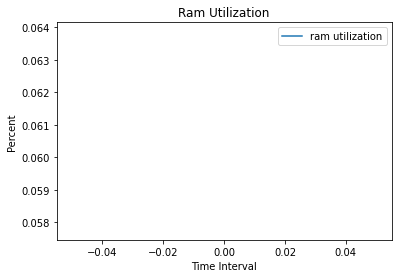

Max Ram Used:  0.720458984375
Max Ram Utilization:  0.06080457631189389
Max GPU:  0
Max CPU:  2
sklearn accuracy =  0.45652173913043476
Elapsed Time: 42.84ms

Monitoring Data for:  SkLearn Nearest Neighbors
printing plot


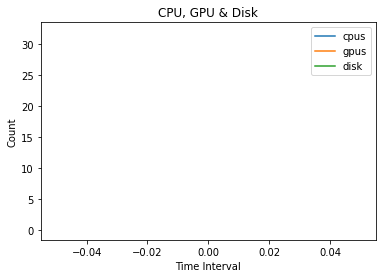

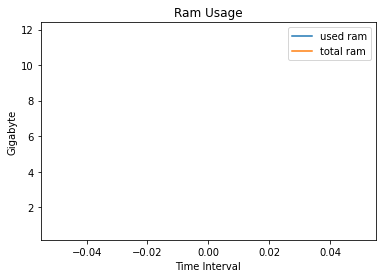

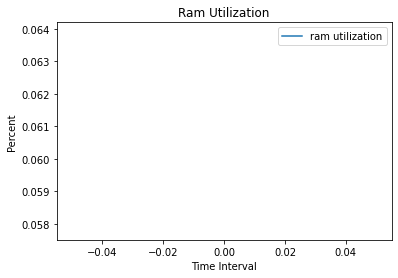

Max Ram Used:  0.72100830078125
Max Ram Utilization:  0.06085338592903894
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          49.619048
sex           0.642857
cp            2.896825
trestbps    128.508377
chol        207.286446
restecg       0.510799
thalach     144.922093
exang         0.210992
oldpeak       0.471296
dtype: float64
Mode Archetype:
age          54.0
sex           1.0
cp            4.0
trestbps    120.0
chol          0.0
restecg       0.0
thalach     160.0
exang         0.0
oldpeak       0.0
Name: 0, dtype: float64


In [ ]:
def executeKnnOnDataSet(k, train_dataset, train_features, train_labels, 
                        validate_dataset, validate_features, validate_labels, mode=None):
  
  tf_nearest_neighbors_monitor = Monitor(0.25)      
  start_time = time.time()
    
  sess = tf.compat.v1.Session()
  with sess.as_default():
    predictedLabels = []
    for i in range(len(validate_dataset)):
      computeDistance = tf.math.reduce_euclidean_norm(train_dataset - validate_dataset[i], axis=1) 
      findKClosestSamples = tf.argsort(computeDistance, direction='ASCENDING') 
      findLabelsKClosestSamples = tf.gather(train_labels, findKClosestSamples[0:k])
      uniqueLabels, indices, counts = tf.unique_with_counts(findLabelsKClosestSamples) # examine labels of k closest Train images

      # Take the most frequently occuring label as the predicted value.
      findPredictedLabel = tf.gather(uniqueLabels, tf.argmax(counts))
      if tf.executing_eagerly():
        predictedLabels += [findPredictedLabel.numpy()]
      else:
        predictedLabels += [findPredictedLabel.eval()]
      

    tf_nearest_neighbors_monitor.stop()

    equals = tf.equal(predictedLabels, validate_labels)
    equals_as_ints = tf.cast(equals, tf.int32)
    equals_count = tf.reduce_sum(equals_as_ints)
    
    if tf.executing_eagerly():
      accuracy = equals_count.numpy() / len(validate_labels)
    else:
      accuracy = equals_count.eval() / len(validate_labels)
      

    if mode == "test":
      print("Tensorflow accuracy = ", accuracy)
      true_samples_indices = tf.where(equals)
      print("Archetype of a True prediction:")
      mean_archetype, mode_archetype = getRepresentativeSampleArchetype(validate_features, true_samples_indices)

      print("Mean Archetpye:")
      print(mean_archetype)
      print("Mode Archetype:")
      print(mode_archetype)   

      end_time = time.time()
      elapsed_time = end_time - start_time
      print("Elapsed Time: {t:.2F}ms".format(t=(elapsed_time * 1000)))
      printMonitorData(tf_nearest_neighbors_monitor,"Tensorflow Nearest Neighbors")

  
  gc.collect()
  tf.compat.v1.reset_default_graph()
  K.clear_session()

  return accuracy



def determineOptimalK(train_dataset, train_features, train_labels, 
                        validate_dataset, validate_features, validate_labels):

  accuracyToK = {}  
  optimalK = 1

  for k in range(1, len(validate_dataset)):
    accuracy = executeKnnOnDataSet(k, train_dataset, train_features, train_labels, 
                        validate_dataset, validate_features, validate_labels)
   
    accuracyToK[accuracy] = k

  highestAccuracy = max(accuracyToK.keys())
  bestK = accuracyToK[highestAccuracy]

  return bestK


def doSkLearnKNearestNeighbors(optimalK, train_features, train_labels, 
                        test_features, test_labels):
  sklearn_nearest_neighbors_monitor = Monitor(0.25)      
  start_time = time.time()
 
  knnClassifier = KNeighborsClassifier(n_neighbors = optimalK)

  knnClassifier.fit(train_features, train_labels)
  predictions = knnClassifier.predict(test_features)

  print("sklearn accuracy = ", knnClassifier.score(test_features, test_labels))

  sklearn_nearest_neighbors_monitor.stop()
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Elapsed Time: {t:.2F}ms".format(t=(elapsed_time * 1000)))

  # Allow monitoring thread to process.
  time.sleep(2)
  printMonitorData(sklearn_nearest_neighbors_monitor,"SkLearn Nearest Neighbors") 

  equals = (tf.equal(test_labels, predictions))
  true_samples_indices = tf.where(equals)
  print("Archetype of a True prediction:")
  mean_archetype, mode_archetype = getRepresentativeSampleArchetype(test_features, true_samples_indices)

  print("Mean Archetpye:")
  print(mean_archetype)
  print("Mode Archetype:")
  print(mode_archetype)
  
  return 


def evaluateKnn(dataset, dataset_name):
  print("\nEvaluate KNN for: ", dataset_name)
  tf.get_logger().setLevel('FATAL')

  train_dataset, validate_dataset, test_dataset = getTrainTestValidateSplit(dataset)

  train_features = train_dataset.copy()
  train_labels = train_features.pop('num')
  
  validate_features = validate_dataset.copy()
  validate_labels = validate_features.pop('num')

  test_features = test_dataset.copy()
  test_labels = test_features.pop('num')
  
  train_dataset = numpy.array(train_dataset)
  validate_dataset = numpy.array(validate_dataset)
  test_dataset = numpy.array(test_dataset)
  
  
  optimalK = determineOptimalK(train_dataset, train_features, train_labels, 
                        validate_dataset, validate_features, validate_labels)
  
  print("Optimal k = ", optimalK)


  executeKnnOnDataSet(optimalK, train_dataset, train_features, train_labels, 
                        test_dataset, test_features, test_labels, mode='test')
    
  doSkLearnKNearestNeighbors(11, train_features, train_labels, 
                        test_features, test_labels)
  

  return
  
for dataset, dataset_name in zip(datasets, names):
  print("\n\n\n")
  evaluateKnn(dataset.copy(), dataset_name)

print("\n\n\n")
evaluateKnn(combined_dataset.copy(), "Combined Dataset")








Evaluate Gradient Boosting:  imputed_cleveland_dataset


GB Tree Stats:
accuracy          0.592233
average_loss      1.193118
loss              1.193118
global_step     100.000000
dtype: float64
Elapsed Time = 36638.26ms

Monitoring Data for:  Tensorflow Gradient Boosting
printing plot


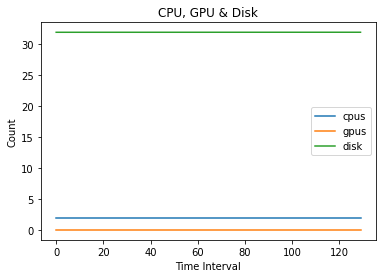

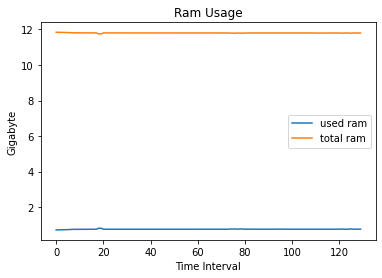

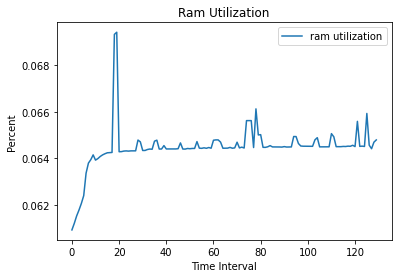

Max Ram Used:  0.8156814575195312
Max Ram Utilization:  0.06941534905539405
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          51.737705
sex           0.655738
cp            3.016393
trestbps    131.672131
chol        243.590164
fbs           0.180328
restecg       0.786885
thalach     157.131148
exang         0.196721
oldpeak       0.529508
slope         1.459016
ca            0.289709
thal          4.208758
dtype: float64
Mode Archetype:
age          42.0
sex           1.0
cp            4.0
trestbps    140.0
chol        219.0
fbs           0.0
restecg       0.0
thalach     152.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
Name: 0, dtype: float64


SkLearn Accuracy =  0.5533980582524272
Elapsed Time: 529.53ms

Monitoring Data for:  SkLearn Gradient Boosting
printing plot


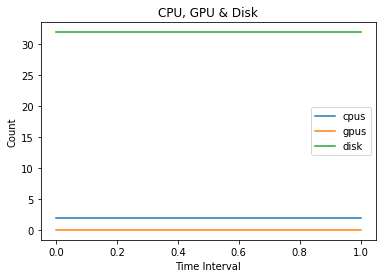

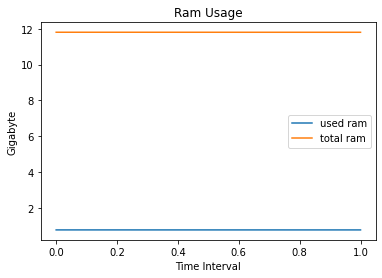

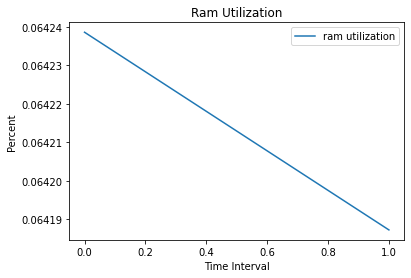

Max Ram Used:  0.758514404296875
Max Ram Utilization:  0.06423858346880597
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          51.842105
sex           0.578947
cp            3.052632
trestbps    132.000000
chol        247.000000
fbs           0.140351
restecg       0.771930
thalach     158.526316
exang         0.157895
oldpeak       0.545614
slope         1.456140
ca            0.333333
thal          3.837442
dtype: float64
Mode Archetype:
age          42.0
sex           1.0
cp            4.0
trestbps    140.0
chol        219.0
fbs           0.0
restecg       0.0
thalach     152.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
Name: 0, dtype: float64





Evaluate Gradient Boosting:  imputed_hungarian_dataset


GB Tree Stats:
accuracy          0.760000
average_loss      0.554355
loss              0.554355
global_step     100.000000
dtype: float64
Elapsed Time = 19780.67ms

Monitoring Data for:  Tensorflow Gradi

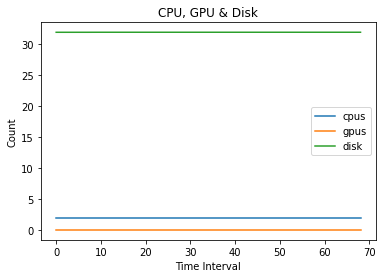

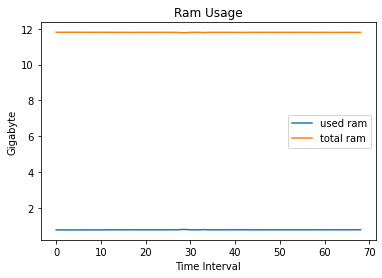

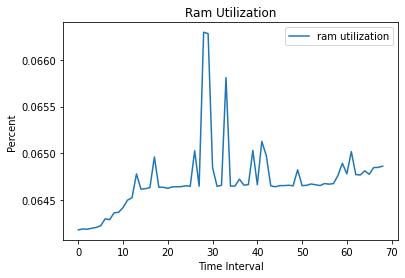

Max Ram Used:  0.781097412109375
Max Ram Utilization:  0.06629611726085269
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          47.565789
sex           0.763158
cp            2.842105
trestbps    133.171053
chol        253.012381
fbs           0.080788
restecg       0.184211
thalach     137.486842
exang         0.315789
oldpeak       0.585526
dtype: float64
Mode Archetype:
age          54.000000
sex           1.000000
cp            2.000000
trestbps    120.000000
chol        250.848708
fbs           0.000000
restecg       0.000000
thalach     150.000000
exang         0.000000
oldpeak       0.000000
Name: 0, dtype: float64


SkLearn Accuracy =  0.76
Elapsed Time: 99.09ms

Monitoring Data for:  SkLearn Gradient Boosting
printing plot


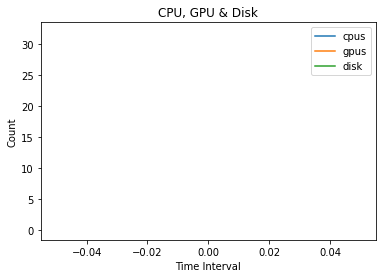

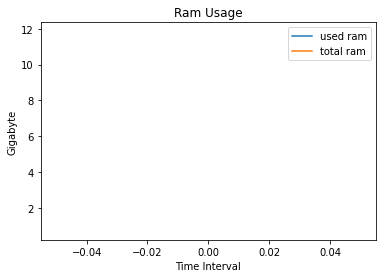

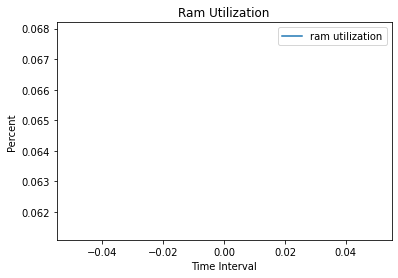

Max Ram Used:  0.7629013061523438
Max Ram Utilization:  0.06464567710520285
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          47.342105
sex           0.776316
cp            2.855263
trestbps    132.236842
chol        250.907118
fbs           0.080788
restecg       0.171053
thalach     138.710526
exang         0.289474
oldpeak       0.585526
dtype: float64
Mode Archetype:
age          54.000000
sex           1.000000
cp            2.000000
trestbps    120.000000
chol        250.848708
fbs           0.000000
restecg       0.000000
thalach     150.000000
exang         0.000000
oldpeak       0.000000
Name: 0, dtype: float64





Evaluate Gradient Boosting:  imputed_switzerland_dataset


GB Tree Stats:
accuracy          0.428571
average_loss      2.194799
loss              2.194799
global_step     100.000000
dtype: float64
Elapsed Time = 24385.51ms

Monitoring Data for:  Tensorflow Gradient Boosting
printing plot


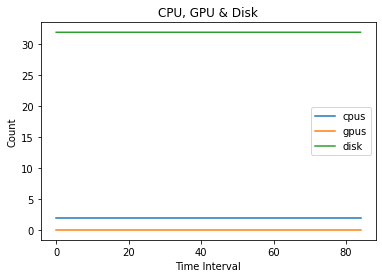

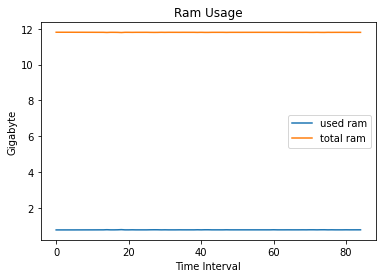

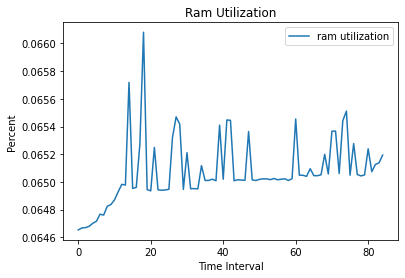

Max Ram Used:  0.77880859375
Max Ram Utilization:  0.06608107749443444
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          59.222222
sex           1.000000
cp            3.888889
trestbps    132.233701
chol          0.000000
restecg       0.388889
thalach     107.475410
exang         0.524590
oldpeak       0.922650
slope         1.744759
thal          6.128326
dtype: float64
Mode Archetype:
age          60.000000
sex           1.000000
cp            4.000000
trestbps    115.000000
chol          0.000000
restecg       0.000000
thalach     110.000000
exang         1.000000
oldpeak       0.000000
slope         2.000000
thal          5.788732
Name: 0, dtype: float64


SkLearn Accuracy =  0.35714285714285715
Elapsed Time: 375.34ms

Monitoring Data for:  SkLearn Gradient Boosting
printing plot


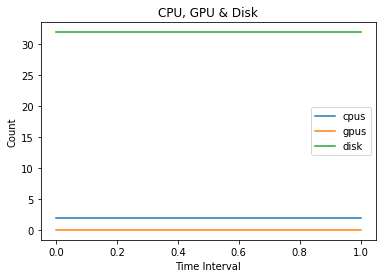

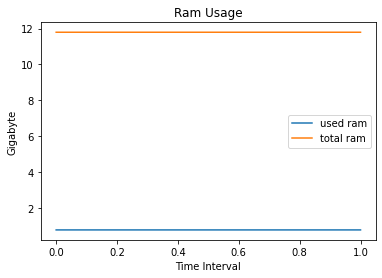

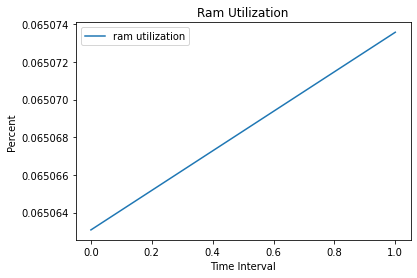

Max Ram Used:  0.7676773071289062
Max Ram Utilization:  0.06507358053115087
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          57.466667
sex           1.000000
cp            3.866667
trestbps    134.013774
chol          0.000000
restecg       0.333333
thalach     107.503825
exang         0.562842
oldpeak       0.790769
slope         1.867296
thal          5.662911
dtype: float64
Mode Archetype:
age          60.000000
sex           1.000000
cp            4.000000
trestbps    130.000000
chol          0.000000
restecg       0.000000
thalach     120.000000
exang         1.000000
oldpeak       0.000000
slope         1.801887
thal          5.788732
Name: 0, dtype: float64





Evaluate Gradient Boosting:  imputed_long_beach_dataset


GB Tree Stats:
accuracy          0.367647
average_loss      2.058210
loss              2.058210
global_step     100.000000
dtype: float64
Elapsed Time = 20600.35ms

Monitoring Data for:  Tensorflow Gradient Boosting
printing plo

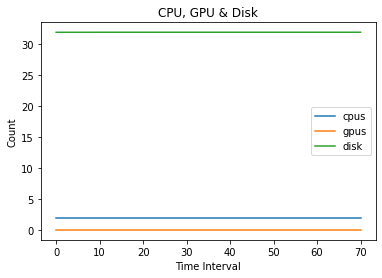

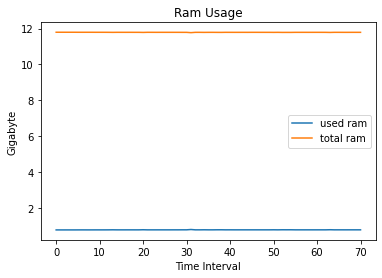

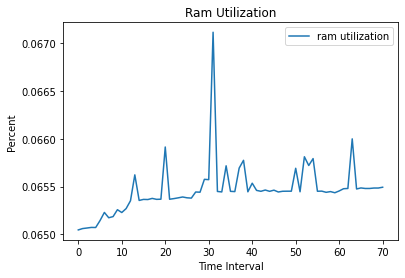

Max Ram Used:  0.7902374267578125
Max Ram Utilization:  0.06711247193198948
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          59.240000
sex           0.960000
cp            3.360000
trestbps    128.545556
chol        173.880000
fbs           0.374093
restecg       0.840000
thalach     120.246531
exang         0.672653
oldpeak       1.375500
dtype: float64
Mode Archetype:
age          51.000000
sex           1.000000
cp            4.000000
trestbps    133.763889
chol          0.000000
fbs           0.000000
restecg       1.000000
thalach     122.795918
exang         1.000000
oldpeak       1.320833
Name: 0, dtype: float64


SkLearn Accuracy =  0.3088235294117647
Elapsed Time: 439.88ms

Monitoring Data for:  SkLearn Gradient Boosting
printing plot


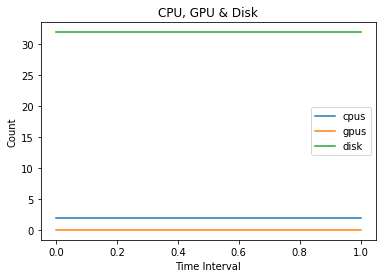

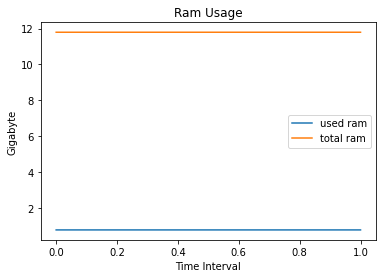

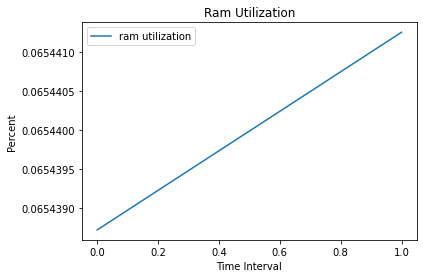

Max Ram Used:  0.7717552185058594
Max Ram Utilization:  0.06544125971618864
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          59.809524
sex           0.952381
cp            3.571429
trestbps    134.123016
chol        158.380952
fbs           0.397730
restecg       0.857143
thalach     120.846453
exang         0.660836
oldpeak       1.391667
dtype: float64
Mode Archetype:
age          63.000000
sex           1.000000
cp            4.000000
trestbps    133.763889
chol          0.000000
fbs           0.000000
restecg       1.000000
thalach     122.795918
exang         1.000000
oldpeak       1.320833
Name: 0, dtype: float64





Evaluate Gradient Boosting:  Combined Dataset


GB Tree Stats:
accuracy          0.622222
average_loss      0.983186
loss              0.983186
global_step     100.000000
dtype: float64
Elapsed Time = 17958.90ms

Monitoring Data for:  Tensorflow Gradient Boosting
printing plot


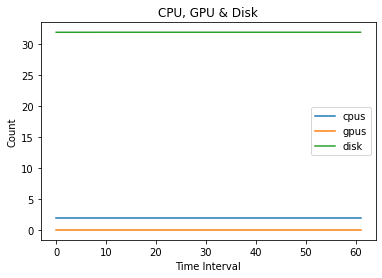

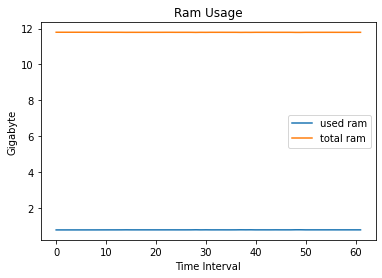

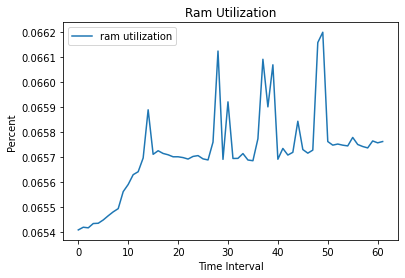

Max Ram Used:  0.7801437377929688
Max Ram Utilization:  0.06620070554524378
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          52.250000
sex           0.607143
cp            3.071429
trestbps    131.277282
chol        218.851740
restecg       0.607143
thalach     137.599854
exang         0.273081
oldpeak       0.840030
dtype: float64
Mode Archetype:
age          54.0
sex           1.0
cp            3.0
trestbps    140.0
chol        220.0
restecg       0.0
thalach     150.0
exang         0.0
oldpeak       0.0
Name: 0, dtype: float64


SkLearn Accuracy =  0.6
Elapsed Time: 776.69ms

Monitoring Data for:  SkLearn Gradient Boosting
printing plot


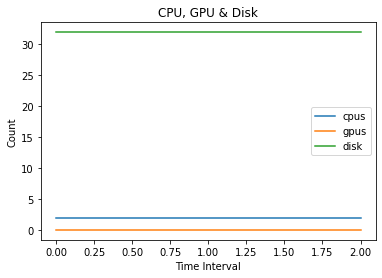

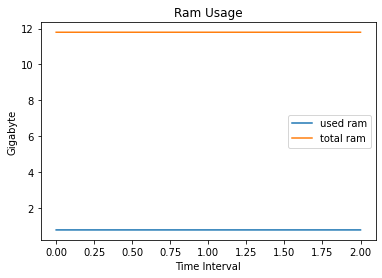

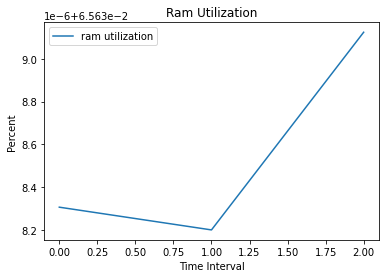

Max Ram Used:  0.7739982604980469
Max Ram Utilization:  0.06563912408702452
Max GPU:  0
Max CPU:  2
Archetype of a True prediction:
Mean Archetpye:
age          50.666667
sex           0.629630
cp            3.074074
trestbps    129.843107
chol        229.401804
restecg       0.629630
thalach     138.214664
exang         0.320232
oldpeak       0.641512
dtype: float64
Mode Archetype:
age          54.0
sex           1.0
cp            3.0
trestbps    120.0
chol        220.0
restecg       0.0
thalach     150.0
exang         0.0
oldpeak       0.0
Name: 0, dtype: float64


In [ ]:
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

def make_input_fn(X, y, num_examples, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(num_examples)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(num_examples)
        return dataset
    return input_fn


def doGradientBoostingRegression(train_features, train_labels, test_features, test_labels):
  sess = tf.compat.v1.Session()
  with sess.as_default():
    tf.get_logger().setLevel('FATAL')
    tf.compat.v1.disable_v2_behavior()
    
    tf_gradient_boosting_monitor = Monitor(0.25)
    start_time = time.time()

    feature_columns = []
    for feature_name in train_features.columns:
      feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                            dtype=tf.float32))

    # Training and evaluation input functions.
    train_input_fn = make_input_fn(train_features, train_labels, len(train_labels))
    eval_input_fn = make_input_fn(test_features, test_labels, len(test_labels), shuffle=False, n_epochs=1)

    # Default learning_rate=0.1, which yields different results for TF vs scikit-learn
    est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                              #learning_rate=0.01,
                                              n_classes=len(feature_columns),
                                              n_batches_per_layer=1)
  
    est.train(train_input_fn, max_steps=100)
    stats = est.evaluate(eval_input_fn)
    result = est.predict(eval_input_fn)

    pred_dicts = list(result)
    predictions = [pred['class_ids'][0] for pred in pred_dicts]
    
    print("\n\nGB Tree Stats:")
    print(pd.Series(stats))

    tf_gradient_boosting_monitor.stop()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Elapsed Time = {t:.2F}ms".format(t=(elapsed_time * 1000)))
    printMonitorData(tf_gradient_boosting_monitor,"Tensorflow Gradient Boosting") 


    equals = (tf.equal(test_labels, predictions))
    true_samples_indices = tf.where(equals)
    print("Archetype of a True prediction:")
    mean_archetype, mode_archetype = getRepresentativeSampleArchetype(test_features, true_samples_indices)

    print("Mean Archetpye:")
    print(mean_archetype)
    print("Mode Archetype:")
    print(mode_archetype)


  gc.collect()
  tf.compat.v1.reset_default_graph()
  K.clear_session()

  return


def doSkLearnGradientBoosting(train_features, train_labels, test_features, test_labels):
  with tf.compat.v1.Session():
    sklearn_gradient_boosting_monitor = Monitor(0.25)      
    start_time = time.time()

    # Default learning_rate=0.1, which yields different results for TF vs scikit-learn
    classifier = GradientBoostingClassifier(random_state=0) #,  learning_rate=0.01)
    classifier.fit(train_features, train_labels)

    #GradientBoostingClassifier(random_state=0)

    predictions = classifier.predict(test_features)

    print("\n\nSkLearn Accuracy = ", classifier.score(test_features, test_labels))

    sklearn_gradient_boosting_monitor.stop()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Elapsed Time: {t:.2F}ms".format(t=(elapsed_time * 1000)))
    
    # Allow monitoring thread to process.
    time.sleep(2)
    printMonitorData(sklearn_gradient_boosting_monitor,"SkLearn Gradient Boosting") 


    equals = (tf.equal(test_labels, predictions))
    true_samples_indices = tf.where(equals)
    print("Archetype of a True prediction:")
    mean_archetype, mode_archetype = getRepresentativeSampleArchetype(test_features, true_samples_indices)

    print("Mean Archetpye:")
    print(mean_archetype)
    print("Mode Archetype:")
    print(mode_archetype)

  gc.collect()
  tf.compat.v1.reset_default_graph()
  K.clear_session()

  return


def evaluateGradientBoosting(dataset, dataset_name):
  print("\nEvaluate Gradient Boosting: ", dataset_name)

  train_dataset = dataset.sample(frac=0.66, random_state=0)
  test_dataset = dataset.drop(train_dataset.index)
    
  train_features = train_dataset.copy()
  test_features = test_dataset.copy()

  train_labels = train_features.pop('num')
  test_labels = test_features.pop('num')

  doGradientBoostingRegression(train_features, train_labels, test_features, test_labels)
  doSkLearnGradientBoosting(train_features, train_labels, test_features, test_labels)

  return

  
for dataset, dataset_name in zip(datasets, names):
  print("\n\n\n")
  evaluateGradientBoosting(dataset.copy(), dataset_name)

print("\n\n\n")
evaluateGradientBoosting(combined_dataset.copy(), "Combined Dataset")

In [ ]:

for dataset, dataset_name in zip(datasets, names):
  print("dataset_name = ", dataset_name)
  print("shape = ", dataset.shape)

print("shape = ", combined_dataset.shape)

dataset_name =  imputed_cleveland_dataset
shape =  (303, 14)
dataset_name =  imputed_hungarian_dataset
shape =  (294, 11)
dataset_name =  imputed_switzerland_dataset
shape =  (123, 12)
dataset_name =  imputed_long_beach_dataset
shape =  (200, 11)
shape =  (920, 10)
